# MODELO PREDITO - FRAUDE BANCÁRIA

O objetivo desta análise preditiva é determinar se determinada transação bancária tem potencial ou não de ser uma fraude. Dessa forma, o modelo auxilia em alertas sobre transações suspeitas e que podem impedir algum tipo de dano ao cliente e ao banco em si. O objetivo desse modelo é ter uma acurácia acima de 80%.

In [1]:
# carregando os pacotes e removendo os avisos
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from matplotlib import pylab
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Carregando o dataset
base = pd.read_csv('C:/python_scripts/fraud/base.csv')

In [3]:
# Conferindo a quantidade de linhas e confirmando que a junção dos dataset está correta
print(base.shape)

(1000000, 32)


## 1. Análise Exploratória

Dataset possui 1 milhão de registros com 32 atributos. Como é um problema de classificação, é esperado que exista um desbalanceamento de classes e também possíveis atributos que estejam correlacionados. A fase de análise exploratória será excelente para identificar esses pontos e determinar quais serão os passos no pré-processamento.

In [4]:
# Visualizando os dados
base.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [5]:
# Tipos de variáveis
base.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

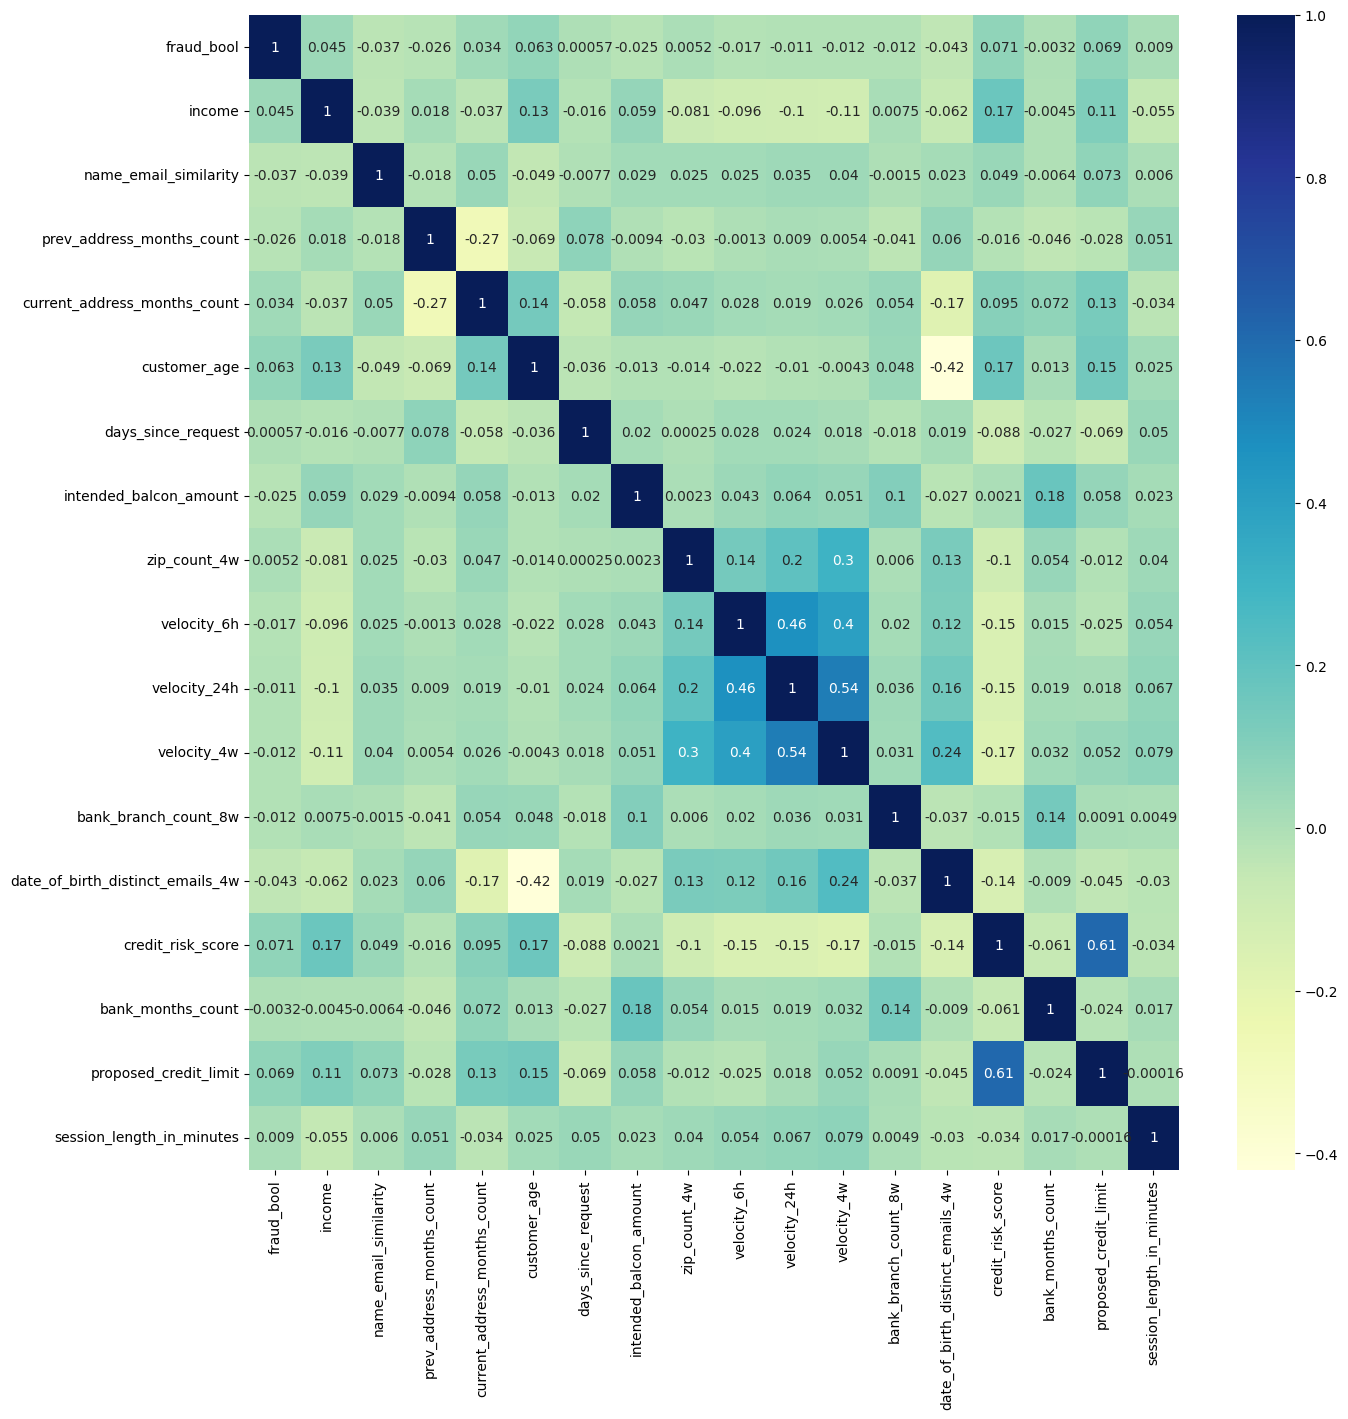

In [6]:
# Gráfico de correlação
fig, ax = plt.subplots(figsize=(15, 15))

dataplot = sns.heatmap(base[['fraud_bool','income','name_email_similarity','prev_address_months_count','current_address_months_count',
                            'customer_age','days_since_request','intended_balcon_amount','zip_count_4w', 'velocity_6h','velocity_24h',
                            'velocity_4w','bank_branch_count_8w','date_of_birth_distinct_emails_4w','credit_risk_score',
                            'bank_months_count','proposed_credit_limit','session_length_in_minutes']].corr(), 
                       cmap="YlGnBu", 
                       annot=True)

Analisando a correlação das 32 variáveis, temos algumas observações interessantes.

A primeira é que em relação a velocidade de transação de 6h, 24h e 4 sem. tem uma alta correlação entre si. Isso pode indicar que o modelo pode ficar tendecioso com o uso de todas essas variáveis. Dessa forma, é interessante testar com todas e depois com elas separadamente.

Outro ponto é que temos duas variáveis com uma alta correlação, credir_risk_score e proposed_credit_limit, e uma com baixa correlação, date_of_birth_distinct_emails_4w e  customer_age. A análise é a mesma feita no paragráfo anterior.

O total de registros é: 1000000
A classe 1 possui 11029 que representa 1.1 %
A classe 0 possui: 988971 que representa 98.9 %


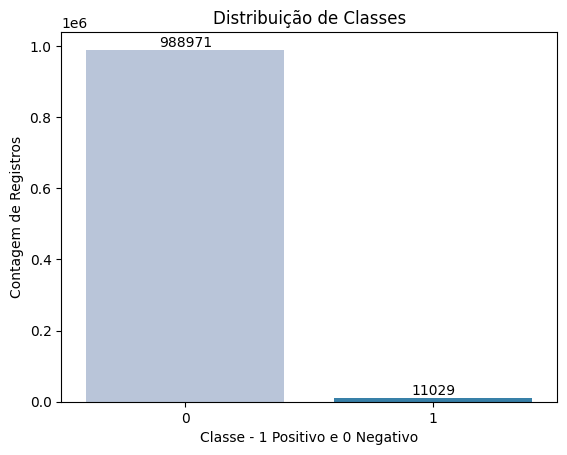

In [7]:
# Gráfico para contagem de classes na variável Fraud Bool (Variável target)
graf_class = sns.countplot(x = 'fraud_bool', data = base, palette = 'PuBu')
graf_class.set_xlabel('Classe - 1 Positivo e 0 Negativo')
graf_class.set_ylabel('Contagem de Registros')
graf_class.set_title('Distribuição de Classes')

graf_class.bar_label(graf_class.containers[0])

class_table = base['fraud_bool'].value_counts()

print('O total de registros é:', class_table.sum())
print('A classe 1 possui', class_table[1].sum(), 'que representa', round((class_table[1]/class_table.sum())*100,1),"%")
print('A classe 0 possui:', class_table[0].sum(), 'que representa', round((class_table[0]/class_table.sum())*100,1),"%")

Aqui vemos que o dataset está desbalanceado, o que era esperado visto que temos muito mais transações legais do que fraudulentas no mercado. Diante disso, será necessário fazer um balanceamento de classes porque apenas 1% das transações tiveram fraude. Usar o dataset dessa forma prejudica o treinamento do modelo de machine learning.

In [8]:
# Slicing para apenas transações com fraude
base_fraud = base[base.fraud_bool == 1]
base_fraud.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [9]:
# Print do número de linhas, confirmado que o slicing está correto
print(base_fraud.shape)

(11029, 32)


Text(0.5, 1.0, 'Histograma - Idade')

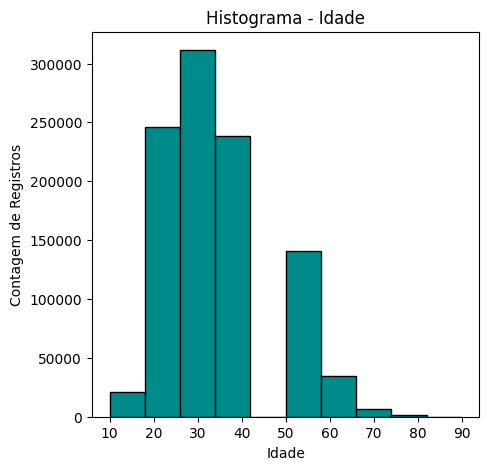

In [10]:
# Histograma da Idade

fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(base['customer_age'], color = 'darkcyan', edgecolor = 'black')
plt.ylabel('Contagem de Registros')
plt.xlabel('Idade')
plt.title('Histograma - Idade')

Pelo histograma vemos que as transações ocorrem em diversas faixas etárias, principalmente entre 20 e 50 anos (que é a faixa que mais utiliza).

Text(0.5, 1.0, 'Transações com Fraude por Idade')

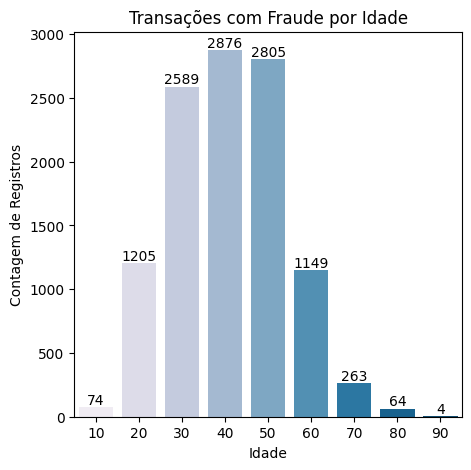

In [11]:
# Gráfico de barras fraude por idade

fig, ax = plt.subplots(figsize=(5, 5))
graf_class = sns.countplot(x = 'customer_age', 
                           data = base_fraud, 
                           palette = 'PuBu')
graf_class.bar_label(graf_class.containers[0])
graf_class.set_xlabel('Idade')
graf_class.set_ylabel('Contagem de Registros')
graf_class.set_title('Transações com Fraude por Idade')

Neste exemplo vemos que as maiores transações com algum tipo de fraude gira em torno de idade que vão de 30 a 50 anos de idade, que é a faixa que mais utiliza.

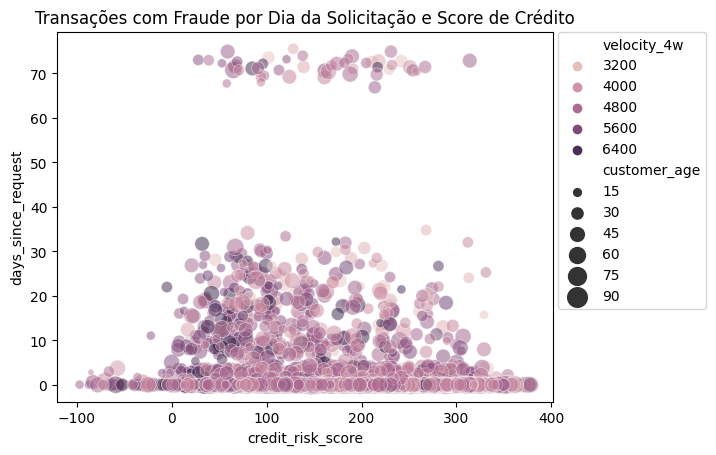

In [12]:
#Bubble chart
grafico_bolhas = sns.scatterplot(data = base_fraud, 
                x = "credit_risk_score", 
                y= "days_since_request", 
                size="customer_age", 
                legend = True,
                hue = 'velocity_4w',
                sizes=(20,200),
                alpha=0.5)

# Coloca título no gráfico
grafico_bolhas.set_title('Transações com Fraude por Dia da Solicitação e Score de Crédito')

# Coloca a legenda fora do gráfico
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

# Mostra o gráfico
plt.show()

No gráfico acima temos uma visão com o score do risco de crédito no eixo X, a quantidade de dias que passaram após a aplicação bancária ter sido feita em Y, velocidade das aplicações bancárias em 4 semanas e a idade dos clientes. Ao olhar o gráfico, que contém apenas transações com suspeita de fraude, vemos que os primeiros dias são os mais frequentes quando se tratam de fraude.

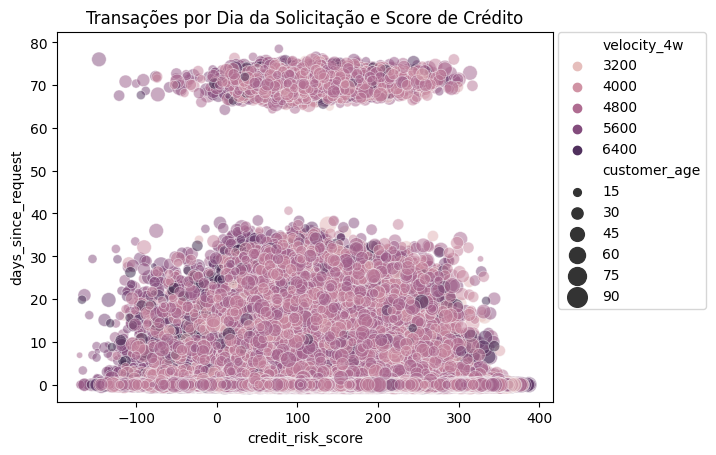

In [13]:
#Bubble chart
grafico_bolhas2 = sns.scatterplot(data = base, 
                x = "credit_risk_score", 
                y= "days_since_request", 
                size="customer_age", 
                legend = True,
                hue = 'velocity_4w',
                sizes=(20,200),
                alpha=0.5)

# Coloca título no gráfico
grafico_bolhas2.set_title('Transações por Dia da Solicitação e Score de Crédito')

# Coloca a legenda fora do gráfico
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

# Mostra o gráfico
plt.show()

Quando analisamos com todas as transações, incluindo fraude, notamos que o comportamento é parecido. Contudo, quando é fraude o dias que se passaram é menor e o risco de crédito tende a se concentrar entre 0 a 100 porque fica nítido que temos uma concentração maior nesse quadrante do gráfico.

Text(0.5, 1.0, 'Fraude por Status do Emprego')

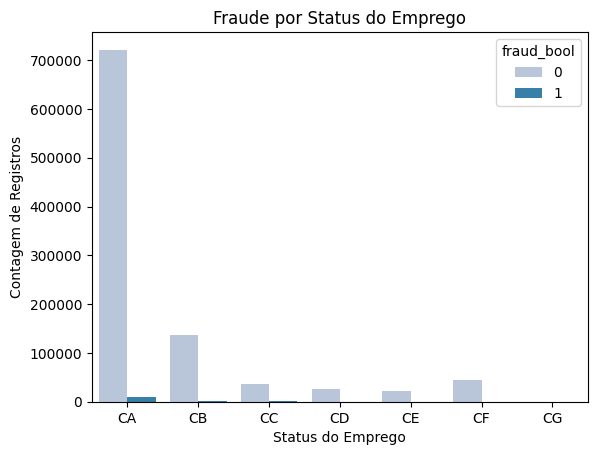

In [14]:
# Gráfico de barras
count_plot = sns.countplot(x = "employment_status", 
                           data = base,
                           hue = 'fraud_bool',
                           palette = 'PuBu')

# Formatação dos eixos do gráfico e título
count_plot.set_ylabel('Contagem de Registros')
count_plot.set_xlabel('Status do Emprego')
count_plot.set_title('Fraude por Status do Emprego')

Ao analisar o gráfico por tipo status do emprego, vemos que o tipo CA apresenta uma contagem maior de registros com fraude. Vale ressaltar que esses registros do emprego estão de forma anônima muito em função da LGPD. É uma informação interessante porque no momento do balanceamento de classes, pode ser inserido registros CA com uma maior quantidade que os demais e isso irá impactar o dataset de teste e treino de alguma forma.

## 2. PRÉ-PROCESSAMENTO DE DADOS

Nesta etapa será feito ajustes na bases para o processamento da base, como balanceamento e criação de variáveis dummy. Isso se faz necessário por conta dos algoritmos de Machine Learning que podem ser utilizados ao longo do script.

In [15]:
# Clone da base original para ter um backup mais a frente no script
base_modelo = base
base_modelo.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [16]:
# Confere do números de linhas
base_modelo.shape

(1000000, 32)

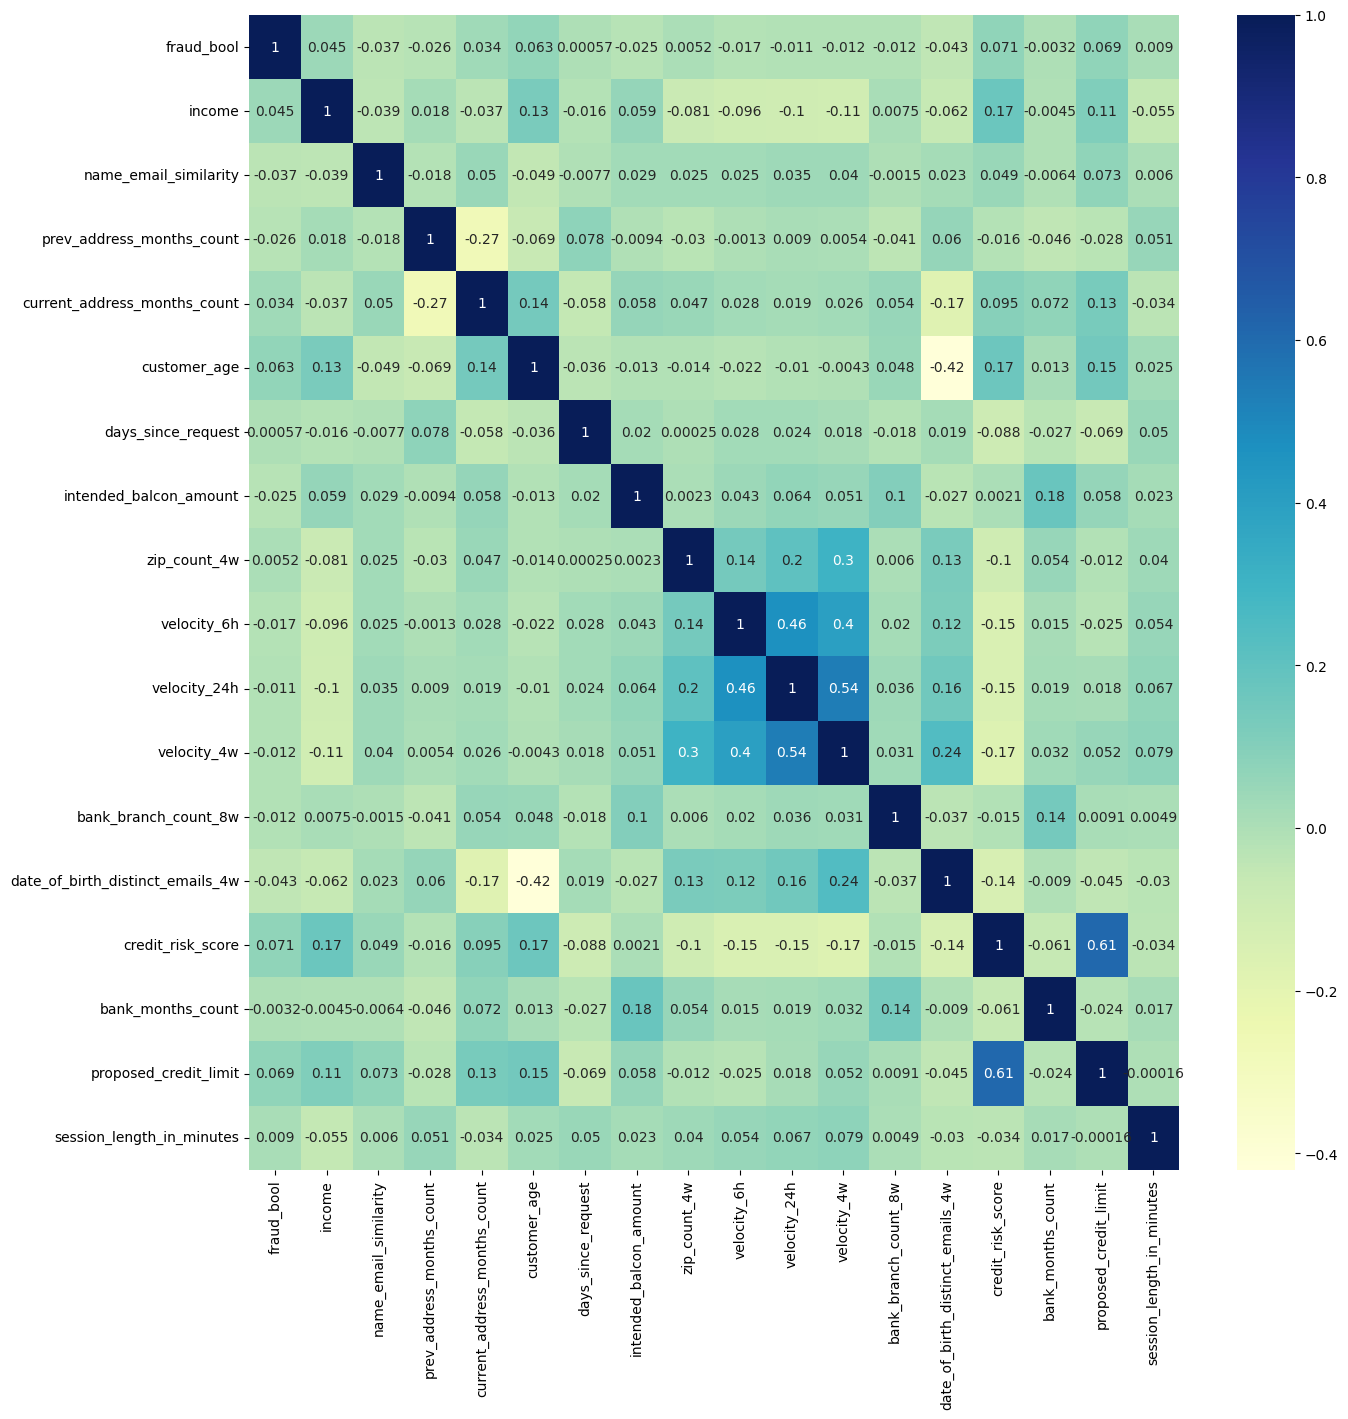

In [17]:
# Gráfico de correlação
fig, ax = plt.subplots(figsize=(15, 15))

dataplot = sns.heatmap(base[['fraud_bool','income','name_email_similarity','prev_address_months_count','current_address_months_count',
                            'customer_age','days_since_request','intended_balcon_amount','zip_count_4w', 'velocity_6h','velocity_24h',
                            'velocity_4w','bank_branch_count_8w','date_of_birth_distinct_emails_4w','credit_risk_score',
                            'bank_months_count','proposed_credit_limit','session_length_in_minutes']].corr(), 
                       cmap="YlGnBu", 
                       annot=True)

O gráfico de dispersão feito na fase de análise inicial e é possível observar que algumas variáveis tendem a ter um correlação alta entre si e isso pode prejudicar a modelo preditivo. Dessa forma, será feita a remoção das variáveis com correlação acima de 0,3 e menor que 0,3 para evitar esse tipo de problema. 

In [18]:
# Verificar se o dataset tem valores nulos.
# Não há valores nulos, mas sabemos temos valores nulos como -1 conforme informado no dicionário de dados
base.isnull().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

In [19]:
# Contagem de variáveis nulas
# No dataset valores nulos estão registrados como -1, será usado um comando para visualizar esses registros
#print(base_modelo2['prev_address_months_count'].value_counts())

print('Valores -1 na variável prev_address_months_count são: ',len(base[base.prev_address_months_count == -1]))
print('Valores -1 na variável current_address_months_count são: ',len(base[base.current_address_months_count == -1]))
print('Valores -1 na variável intended_balcon_amount são: ',len(base[base.intended_balcon_amount == -1]))
print('Valores -1 na variável velocity_6h são: ',len(base[base.velocity_6h == -1]))
print('Valores -1 na variável bank_months_count são: ',len(base[base.bank_months_count == -1]))
print('Valores -1 na variável session_length_in_minutes são: ',len(base[base.session_length_in_minutes == -1]))

Valores -1 na variável prev_address_months_count são:  712920
Valores -1 na variável current_address_months_count são:  4254
Valores -1 na variável intended_balcon_amount são:  0
Valores -1 na variável velocity_6h são:  0
Valores -1 na variável bank_months_count são:  253635
Valores -1 na variável session_length_in_minutes são:  2015


Com base na quantidade de registros com valor -1 das variáveis citadas temos muitos registros em prev_address_months_count e bank_months_count. Se remover as linhas com esse registros teremos muitos dados das outras variáveis removidos, o que não é interessante. Por isso será removido a coluna como um todo. Em relação as demais variáveis, é possível manter esses registros porque o número de NAs é muito pequeno frente ao dataset completo com 1 milhão de linhas.

In [20]:
# Comando para remover as colunas com correlação e com muitos valores NAs
base_modelo2 = base_modelo.drop(['velocity_24h', 'velocity_4w', 'bank_months_count','prev_address_months_count','proposed_credit_limit', 'date_of_birth_distinct_emails_4w'], axis=1)
base_modelo2.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,phone_mobile_valid,has_other_cards,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,88,50,0.020925,-1.331345,AA,769,10650.765523,...,0,0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,144,50,0.005418,-0.816224,AB,366,534.047319,...,0,0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,132,40,3.108549,-0.755728,AC,870,4048.534263,...,1,0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,22,50,0.019079,-1.205124,AB,810,3457.064063,...,1,1,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,218,50,0.004441,-0.773276,AB,890,5020.341679,...,0,0,0,INTERNET,3.775225,macintosh,1,1,0,7


O total de registros é: 1000000
A classe 1 possui 11029 que representa 1.1 %
A classe 0 possui: 988971 que representa 98.9 %


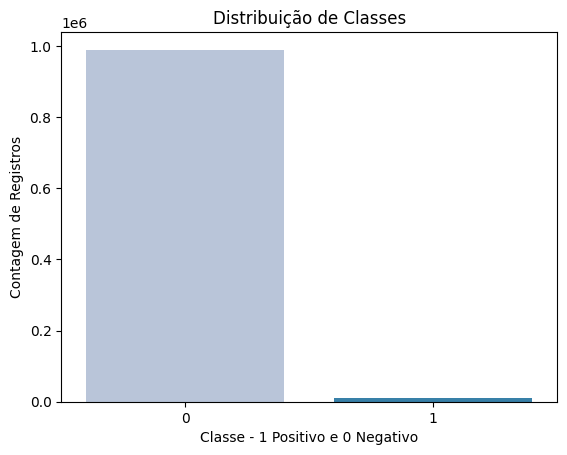

In [21]:
# Gráfico para contagem de classes na variável Fraud Bool (Variável target)
graf_class3 = sns.countplot(x = 'fraud_bool', data = base_modelo2, palette = 'PuBu')
graf_class3.set_xlabel('Classe - 1 Positivo e 0 Negativo')
graf_class3.set_ylabel('Contagem de Registros')
graf_class3.set_title('Distribuição de Classes')

class_table = base_modelo2['fraud_bool'].value_counts()

print('O total de registros é:', class_table.sum())
print('A classe 1 possui', class_table[1].sum(), 'que representa', round((class_table[1]/class_table.sum())*100,1),"%")
print('A classe 0 possui:', class_table[0].sum(), 'que representa', round((class_table[0]/class_table.sum())*100,1),"%")

In [22]:
# Confere do números de linhas e colunas
base_modelo2.shape

(1000000, 26)

In [23]:
# Confere os tipos de dados
base_modelo2.dtypes

fraud_bool                        int64
income                          float64
name_email_similarity           float64
current_address_months_count      int64
customer_age                      int64
days_since_request              float64
intended_balcon_amount          float64
payment_type                     object
zip_count_4w                      int64
velocity_6h                     float64
bank_branch_count_8w              int64
employment_status                object
credit_risk_score                 int64
email_is_free                     int64
housing_status                   object
phone_home_valid                  int64
phone_mobile_valid                int64
has_other_cards                   int64
foreign_request                   int64
source                           object
session_length_in_minutes       float64
device_os                        object
keep_alive_session                int64
device_distinct_emails_8w         int64
device_fraud_count                int64


O balanceamento de classes se aplica somente a variáveis numéricas e por isso será usado com variáveis dummy. Em relação a esta segunda técnica, existe um código já pronto em R para usar e aproveitando este pré-processamento será necessário normalizar as variáveis também, que será feito em R.

In [24]:
# Exporta o dataset em csv para ser usado no R
# Ver script frad_analytics.R que está localizado neste repositório do GitHub.
base_modelo2.to_csv('bd_fraudPython.csv', index = False)

In [25]:
# Importa o dataset em csv para ser usado no R
# Ver script frad_analytics.R que está localizado neste repositório do GitHub.
base_final = pd.read_csv('C:/python_scripts/fraud/bd_final.csv', sep = ';', decimal = ',')
base_final.head()

,income0.2,income0.3,income0.4,income0.5,income0.6,income0.7,income0.8,income0.9,name_email_similarity,current_address_months_count,...,device_distinct_emails_8w,device_fraud_count,month1,month2,month3,month4,month5,month6,month7,fraud_bool
0,0,0,0,0,0,0,0,1,-1.130537,0.015973,...,1,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,1,-0.682778,0.649410,...,1,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,1,-1.551955,0.513674,...,1,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,1,-1.155843,-0.730577,...,1,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,1,0.355278,1.486452,...,1,0,0,0,0,0,0,0,1,1


In [26]:
# Confere os dados do dataset
# Temos colunas como object, o que prejudica o balanceamento de classes. As variáveis precisam ser int64.
base_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 62 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   income0.2                     1000000 non-null  int64  
 1   income0.3                     1000000 non-null  int64  
 2   income0.4                     1000000 non-null  int64  
 3   income0.5                     1000000 non-null  int64  
 4   income0.6                     1000000 non-null  int64  
 5   income0.7                     1000000 non-null  int64  
 6   income0.8                     1000000 non-null  int64  
 7   income0.9                     1000000 non-null  int64  
 8   name_email_similarity         1000000 non-null  float64
 9   current_address_months_count  1000000 non-null  float64
 10  customer_age20                1000000 non-null  int64  
 11  customer_age30                1000000 non-null  int64  
 12  customer_age40               

In [27]:
# Balanceamento de Classes

# Divisão de x e y para o SMOTE
x = base_final.iloc[:, 0:61]
y = base_final.iloc[:, 61]

# Cria o balanceador SMOTE
smote_bal = SMOTE()

# Aplica o balanceador SMOTE
x_res, y_res = smote_bal.fit_resample(x, y)

[Text(0, 0, '988971'), Text(0, 0, '988971')]

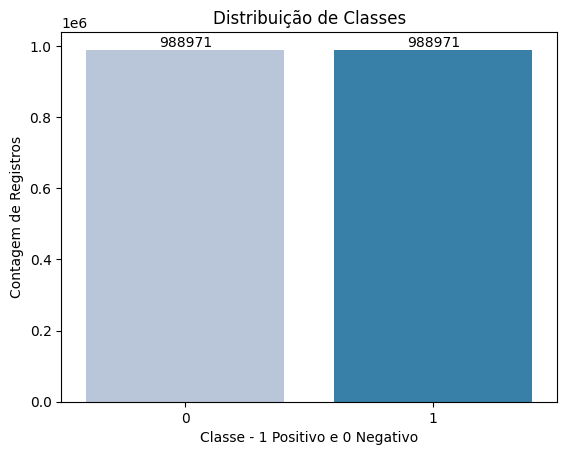

In [28]:
# Classes foram balanceadas conforme o gráfico abaixo.

graf_class2 = sns.countplot(x = y_res, palette = 'PuBu')
graf_class2.set_xlabel('Classe - 1 Positivo e 0 Negativo')
graf_class2.set_ylabel('Contagem de Registros')
graf_class2.set_title('Distribuição de Classes')

graf_class2.bar_label(graf_class2.containers[0])

In [29]:
# Concatenando datasets X e Y
df_final = pd.concat([x_res, y_res], axis = 1, ignore_index = True)

In [31]:
# Divisão de x e y para uso do TRAIN, TESTE e SPLIT
x = df_final.iloc[:, 0:61]
y = df_final.iloc[:, 61]

In [32]:
# Divisão dos dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.3)

## 3. MODELO PREDITIVO

Nesta seção será feita a aplicação do modelo preditivo, o modelo em si será de classificação por conta da variável preditora ser do tipo booleana, ou seja, 0 ou 1. Será feito o teste com ao menos 3 modelos para determinar qual será o modelo utilizado.

### 3.1 Regressão Logística

In [33]:
# Modelo de Regressão Logística

# Cria o modelo
modelo_logistic = LogisticRegression()

In [34]:
# Fit do modelo
modelo_logistic.fit(x_treino,y_treino)

LogisticRegression()

In [35]:
# Previsões com o modelo
previsoes_1 = modelo_logistic.predict(x_teste)

#### 3.1.1 Resultados Regressão Logística

O modelo apresentou uma acurácia acima de 90%, o que significa que todas as técnicas de pré-processamento tiveram um impacto extremamente positivo. Em outras palavras, com as informações deste dataset temos uma probilidade acima de 90% para identificar se a transação bancária teve ou não algum tipo de fraude.

In [36]:
# Dados do Modelo
# O modelo apresentou resultados satisfatórios com uma precisão e acurácia acima de 90%.

Logistic_model = {'Modelo':'Regressão Logística',
                  'Precision':round(precision_score(previsoes_1, y_teste),4),
                  'Recall':round(recall_score(previsoes_1, y_teste),4),
                  'F1 Score':round(f1_score(previsoes_1, y_teste),4),
                  'Acurácia':round(accuracy_score(previsoes_1, y_teste),4),
                  'AUC':round(roc_auc_score(y_teste, previsoes_1),4)}



print('Resultado do Modelo 1:\n')
Logistic_model

Resultado do Modelo 1:



{'Modelo': 'Regressão Logística',
 'Precision': 0.9396,
 'Recall': 0.9286,
 'F1 Score': 0.9341,
 'Acurácia': 0.9337,
 'AUC': 0.9337}

Quando falamos de problemas que envolvem classificação em Machine Learning é importante analisar a Confusion Matrix dos resultados. No caso da Regressão Logística, temos uma clara visão de que o modelo está muito bem equilibrado entre o True Positive (quando o resultado real é 1 e o modelo previu como 1) e True Negative (quando o resultado real é 0 e o modelo previu como 0). Isso acontece por conta do balanceamento de classes que foi feito no pré-processamento dos dados. 

Os demais quadrantes são os erros do modelo, ou seja, qual a classe que ele previu e errou. Este também apresenta um equilíbrio interessante demonstrando que o modelo está balanceado e generalizado.

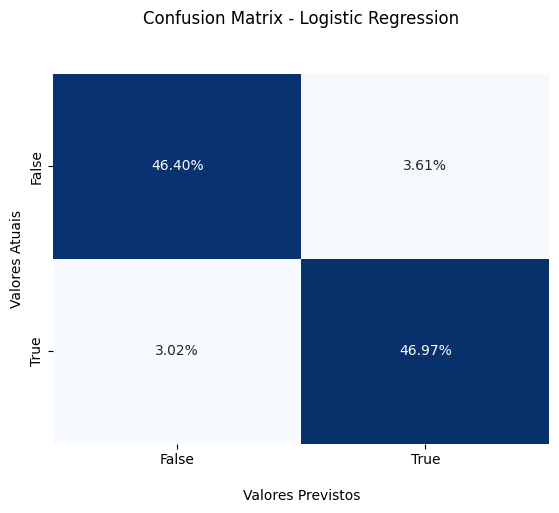

In [37]:
# Confusion Matrix

cf_matrix = confusion_matrix(y_teste, previsoes_1)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False)

ax.set_title('Confusion Matrix - Logistic Regression\n\n');
ax.set_xlabel('\nValores Previstos')
ax.set_ylabel('Valores Atuais');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### 3.2 Modelo com Árvore de Decisão

In [38]:
# Cria o modelo
modelo_arvore = DecisionTreeClassifier()

In [39]:
# Fit do modelo
modelo_arvore.fit(x_treino, y_treino)

DecisionTreeClassifier()

In [40]:
# Previsões com o modelo
previsoes_2 = modelo_arvore.predict(x_teste)

#### 3.2.1 Resultados Árvore de Decisão

O modelo apresentou uma acurácia acima de 90%, o que significa que todas as técnicas de pré-processamento tiveram um impacto extremamente positivo. Em outras palavras, com as informações deste dataset temos uma probilidade acima de 90% para identificar se a transação bancária teve ou não algum tipo de fraude.

In [41]:
# Dados do Modelo
# O modelo apresentou resultados satisfatórios com uma precisão e acurácia acima de 85%.

DecisionTree_model = {'Modelo':'Árvore de Decisão',
                  'Precision':round(precision_score(previsoes_2, y_teste),4),
                  'Recall':round(recall_score(previsoes_2, y_teste),4),
                  'F1 Score':round(f1_score(previsoes_2, y_teste),4),
                  'Acurácia':round(accuracy_score(previsoes_2, y_teste),4),
                  'AUC':round(roc_auc_score(y_teste, previsoes_2),4)}



print('Resultado do Modelo 2:\n')
DecisionTree_model

Resultado do Modelo 2:



{'Modelo': 'Árvore de Decisão',
 'Precision': 0.9828,
 'Recall': 0.9603,
 'F1 Score': 0.9714,
 'Acurácia': 0.9711,
 'AUC': 0.9711}

Quando falamos de problemas que envolvem classificação em Machine Learning é importante analisar a Confusion Matrix dos resultados. No caso da Regressão Logística, temos uma clara visão de que o modelo está muito bem equilibrado entre o True Positive (quando o resultado real é 1 e o modelo previu como 1) e True Negative (quando o resultado real é 0 e o modelo previu como 0). Isso acontece por conta do balanceamento de classes que foi feito no pré-processamento dos dados. 

Os demais quadrantes são os erros do modelo, ou seja, qual a classe que ele previu e errou. Este também apresenta um equilíbrio interessante demonstrando que o modelo está balanceado e generalizado. Além disso, todos os indicadores foram melhoras consideravelmente em comparação com o modelo de Regressão Logística.

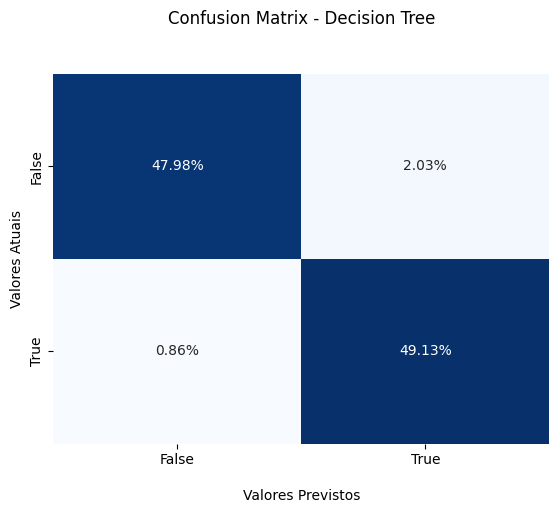

In [42]:
# Confusion Matrix
# Ao analisar a Confusion Matrix, vemos que o modelo teve um ótimo desempenho.
# O True Negative e True Positive tiveram um acerto  muito bom, indicando que o modelo aprendeu corretamente e possui pouco viés na classificação.

cf_matrix = confusion_matrix(y_teste, previsoes_2)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False)

ax.set_title('Confusion Matrix - Decision Tree\n\n');
ax.set_xlabel('\nValores Previstos')
ax.set_ylabel('Valores Atuais');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### 3.3 Modelo com RandomForest

In [43]:
# Cria o modelo
modelo_RandomForest = RandomForestClassifier()

In [44]:
# Fit do modelo
modelo_RandomForest.fit(x_treino, y_treino)

RandomForestClassifier()

#### 3.3.1 Resultados RandomForest

O modelo apresentou uma acurácia próxima de 100%, o que significa que provalmente temos um caso de overfitting neste modelo. Neste caso, não é indicado usá-lo em produção porque o modelo de machine learning deve ser o mais generalista possível e uma taxa de erro já é esperada pelo modelo. 

In [45]:
# Previsões com o modelo
previsoes_3 = modelo_RandomForest.predict(x_teste)

In [46]:
# Dados do Modelo
# O modelo apresentou resultados satisfatórios com uma precisão e acurácia acima de 88%.

RandomForest_model = {'Modelo':'Random Forest',
                  'Precision':round(precision_score(previsoes_3, y_teste),4),
                  'Recall':round(recall_score(previsoes_3, y_teste),4),
                  'F1 Score':round(f1_score(previsoes_3, y_teste),4),
                  'Acurácia':round(accuracy_score(previsoes_3, y_teste),4),
                  'AUC':round(roc_auc_score(y_teste, previsoes_3),4)}



print('Resultado do Modelo 3:\n')
RandomForest_model

Resultado do Modelo 3:



{'Modelo': 'Random Forest',
 'Precision': 0.9939,
 'Recall': 0.9866,
 'F1 Score': 0.9902,
 'Acurácia': 0.9902,
 'AUC': 0.9902}

Ainda em relação ao overfitting, vemos que a Confusion Matrix deixa muito claro que o modelo quase acertou todos os resultados. Isso não é interessante e pode levar a conclusões e análises equivocadas no futuro, caso o modelo entre em produção.

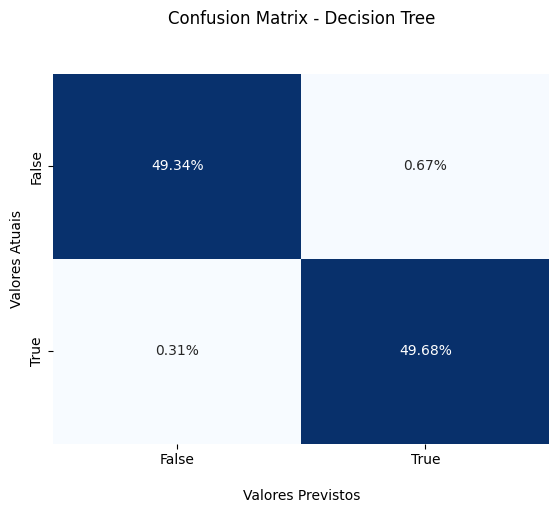

In [47]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_teste, previsoes_3)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False)

ax.set_title('Confusion Matrix - Decision Tree\n\n');
ax.set_xlabel('\nValores Previstos')
ax.set_ylabel('Valores Atuais');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## 4.Conclusão

Entre os 3 modelos, a Árvore de Decisão apresentou o melhor resultado em comparação aos demais. Neste caso, o modelo consegue prever com se uma determinada transação bancária possui ou não fraude com uma probabilidade de 97% de acerto.